In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

from utils.process import categorize
from utils.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

ModuleNotFoundError: No module named 'sklearn'

## Import dataset

In [2]:
# See working directory (No need, just for myself)
os.getcwd()

'/home/brendan/Documents/Jupyter/projet_data'

In [3]:
df = pd.read_csv('./data_cars.csv')

In [4]:
df.head(10)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."
5,27956.0,BMW,X3,2012,95623.0 km,Diesel,automatique,14/03/2018 à 4h24,"modele: X3 F25, version: (F25) XDRIVE35D 313 S..."
6,16888.0,AUDI,A3,2013,49018.0 km,Diesel,mécanique,16/04/2018 à 21h35,"modele: A3 (2E GENERATION) SPORTBACK, version:..."
7,18188.0,RENAULT,MEGANE,2017,9795.0 km,Diesel,automatique,29/04/2018 à 12h44,"modele: MEGANE 4 ESTATE, version: IV ESTATE 1...."
8,10594.0,FORD,C-MAX,2012,126670.0 km,Diesel,mécanique,22/06/2018 à 5h11,"modele: C-MAX 2, version: II 1.6 TDCI 115 FAP ..."
9,69131.0,MERCEDES,CLASSE C,2015,39439.0 km,Essence,automatique,08/03/2018 à 17h35,"modele: CLASSE C 4 AMG, version: (W205) 63 AMG..."


## Observations

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

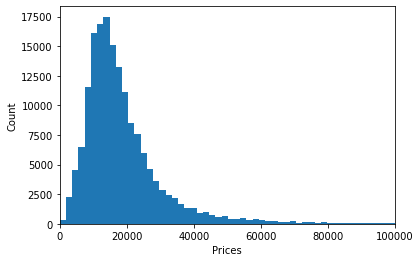

In [6]:
# Price repartition
plt.hist(df["Price"], 800)
plt.xlim(0, 100000)
plt.xlabel('Prices')
plt.ylabel('Count')
plt.show()

Les prix semblent s'agglutiner entre 20000 et 25000 €

In [7]:
# relation between mileage and price
#plt.hist(df['Mileage'],df['Price'])
#plt.xlim(0, 100000)
#plt.xlabel("Mileage")
#plt.ylabel("Price")
#plt.xlim(0, 90000)

Text(0, 0.5, 'Number of cars')

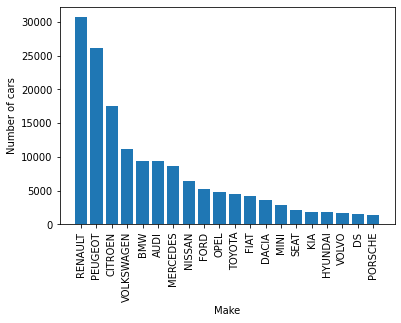

In [8]:
# Make cars counts
counts = df["Make"].value_counts().iloc[0:20]
names = counts.keys().to_numpy()
values = counts.to_numpy()

plt.bar(names, values)
plt.xticks(rotation="vertical")
plt.xlabel("Make")
plt.ylabel("Number of cars")

Le dataset contient beaucoup de voitures Renault, Peugeot et Citroen que de voitures de marque étrangère (BMW, Ford, Mercedes)

## Some data cleaning

### Data Modification

In [9]:
# Getting the number of doors on the car
import re
df['Nbre_porte'] = df['Description'].str.extract("portes: (.)")

In [10]:
# Getting the horse power of a car
df['CV'] = df['Description'].str.extract("puissance_fiscale: (..)")
df['CV'] = df['CV'].str.replace(',', '')

In [11]:
# We choose 2018 because it was the year the sellers published their offers
df['Model_year'] = df.apply(lambda row: 2018 - row.Model_year, axis = 1)
#df.head()

### Data checks

In [12]:
# Check for null values
df.isnull().sum()

Price          0
Make           0
Model          0
Model_year     0
Mileage        0
Fuel           0
Gearbox        0
Online         0
Description    0
Nbre_porte     0
CV             0
dtype: int64

In [13]:
# Check for invalid numbers
df.isna().sum()

Price          0
Make           0
Model          0
Model_year     0
Mileage        0
Fuel           0
Gearbox        0
Online         0
Description    0
Nbre_porte     0
CV             0
dtype: int64

In [14]:
# Find empty strings
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

### Data types conversions

In [15]:
## Remove kilometers and convert to number
df["Mileage"] = df["Mileage"].str.replace(' km', '').astype("float64")
df.head(5)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description,Nbre_porte,CV
0,11220.0,PEUGEOT,308,4,94341.0,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",5,4
1,57526.0,BMW,X6,3,39051.0,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",5,16
2,80379.0,AUDI,RS6,4,75381.0,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",5,47
3,2830.0,FORD,KA,11,92282.0,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",3,5
4,12925.0,FIAT,TIPO,0,10.0,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",5,5


In [16]:
df.dtypes['Mileage']

dtype('float64')

In [17]:
df["Mileage"].isna().sum()

0

In [18]:
# Reduce allocated bytes size for "Model_year" 
df["Model_year"] = df["Model_year"].astype("int16")

In [19]:
# We don't really need the "Online" column as it seems to indicate the last user authentication
df = df.drop("Online", axis=1)
df = df.drop("Description", axis=1)

In [20]:
# This will delete 1000 rows so it not might be the best method
indexNames = df[(df['Nbre_porte'] == ',')].index
df.drop(indexNames , inplace=True)
df['Nbre_porte'] = df['Nbre_porte'].astype(str).astype(int)

In [21]:
df['CV'] = df['CV'].astype(int)

In [22]:
df1 =df

### Hot encoding

In [23]:
# List categorical columns
df["Fuel"].unique()

array(['Diesel', 'Essence', 'Hybride essence électrique', 'Electrique',
       'Hybride diesel électrique', 'Bicarburation essence GPL',
       'Bicarburation essence bioéthanol'], dtype=object)

In [24]:
# List categorical columns for Gearbox
df["Gearbox"].unique()

array(['mécanique', 'automatique'], dtype=object)

In [25]:
df = pd.get_dummies(df, columns=["Gearbox"], drop_first=True)

In [26]:
# List categorical columns
df = pd.get_dummies(df, columns=["Fuel"])

In [27]:
df.head(5)

,Price,Make,Model,Model_year,Mileage,Nbre_porte,CV,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,PEUGEOT,308,4,94341.0,5,4,1,0,0,1,0,0,0,0
1,57526.0,BMW,X6,3,39051.0,5,16,0,0,0,1,0,0,0,0
2,80379.0,AUDI,RS6,4,75381.0,5,47,0,0,0,0,0,1,0,0
3,2830.0,FORD,KA,11,92282.0,3,5,1,0,0,0,0,1,0,0
4,12925.0,FIAT,TIPO,0,10.0,5,5,1,0,0,0,0,1,0,0


In [28]:
np.sort(df['Make'].unique())

array(['ABARTH', 'AC', 'AIXAM', 'ALFA ROMEO', 'ALPINA', 'ALPINE',
       'ASTON MARTIN', 'AUDI', 'AUSTIN', 'AUSTIN HEALEY', 'AUTOBIANCHI',
       'BELLIER', 'BENTLEY', 'BMW', 'BMW-ALPINA', 'BOLLORE', 'BUGATTI',
       'CADILLAC', 'CHATENET', 'CHEVROLET', 'CHRYSLER', 'CITROEN',
       'DACIA', 'DAEWOO', 'DAIHATSU', 'DANGEL', 'DODGE', 'DONKERVOORT',
       'DS', 'FERRARI', 'FIAT', 'FISKER', 'FORD', 'GRECAV', 'HONDA',
       'HUMMER', 'HYUNDAI', 'INFINITI', 'INNOCENTI', 'INTERMECCANICA',
       'JAGUAR', 'JEEP', 'JIAYUAN', 'KIA', 'LADA', 'LAMBORGHINI',
       'LANCIA', 'LAND ROVER', 'LEXUS', 'LIGIER', 'LOTUS', 'MASERATI',
       'MATRA', 'MAZDA', 'MCLAREN', 'MERCEDES', 'MERCEDES-AMG', 'MG',
       'MICROCAR', 'MINI', 'MITSUBISHI', 'MORGAN', 'MPM MOTORS', 'NISSAN',
       'OLDSMOBILE', 'OPEL', 'PACKARD', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'RILEY', 'ROLLS ROYCE', 'ROVER', 'SAAB', 'SEAT', 'SHELBY', 'SIMCA',
       'SKODA', 'SMART', 'SSANGYONG', 'SUBARU', 'SUNBEAM', 'SUZUKI',
       'TES

In [29]:
# Transform makes to ordinal numbers
df['Make'] = categorize(df['Make'])
df['Make'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: Make, dtype: int8

In [30]:
np.sort(df['Model'].unique()[0:60])

array(['2008', '208', '3008', '308', '407', '500', '500 X', '5008', 'A3',
       'A4', 'A5', 'ARONA', 'ASTRA', 'AURIS', 'C-MAX', 'C3', 'C4',
       'C4 PICASSO', 'C5', 'CLASSE A', 'CLASSE B', 'CLASSE C', 'CLASSE R',
       'CLIO', 'DS3', 'DUSTER', 'GOLF', 'GRAND C-MAX',
       'GRAND C4 SPACETOURER', 'GRAND SCENIC', 'I20', 'I30', 'IBIZA',
       'KA', 'KADJAR', 'KOLEOS', 'KUGA', 'MACAN', 'MEGANE', 'MINI',
       'MONDEO', 'PASSAT', 'POLO', 'QASHQAI', 'RS6', 'SANDERO', 'SCENIC',
       'SERIE 1', 'SERIE 2', 'SERIE 3 GT', 'SERIE 5', 'SL', 'TALISMAN',
       'TIGUAN', 'TIPO', 'TOURAN', 'TWINGO', 'X3', 'X6', 'XKR'],
      dtype=object)

In [31]:
# Transform models to ordinal numbers
df['Model'] = categorize(df['Model'])
df['Model'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: Model, dtype: int16

In [32]:
df.head()

,Price,Make,Model,Model_year,Mileage,Nbre_porte,CV,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,0,0,4,94341.0,5,4,1,0,0,1,0,0,0,0
1,57526.0,1,1,3,39051.0,5,16,0,0,0,1,0,0,0,0
2,80379.0,2,2,4,75381.0,5,47,0,0,0,0,0,1,0,0
3,2830.0,3,3,11,92282.0,3,5,1,0,0,0,0,1,0,0
4,12925.0,4,4,0,10.0,5,5,1,0,0,0,0,1,0,0


In [33]:
df.dtypes

Price                                    float64
Make                                        int8
Model                                      int16
Model_year                                 int16
Mileage                                  float64
Nbre_porte                                 int64
CV                                         int64
Gearbox_mécanique                          uint8
Fuel_Bicarburation essence GPL             uint8
Fuel_Bicarburation essence bioéthanol      uint8
Fuel_Diesel                                uint8
Fuel_Electrique                            uint8
Fuel_Essence                               uint8
Fuel_Hybride diesel électrique             uint8
Fuel_Hybride essence électrique            uint8
dtype: object

## Features selection

In [34]:
plt.figure(figsize=(10, 10))
corrplot(corr)

NameError: name 'corrplot' is not defined

In [35]:
df1=df
df1 = (df - df.mean()) / (df.std())

Pour l'instant il n'y a que "CV" qui a un bon taux de correlation avec "Price"

## Split

In [36]:
features = [
    "Make",
    "Model", 
    "Model_year",
    "Mileage",
    "Fuel_Bicarburation essence GPL",
    "Fuel_Bicarburation essence bioéthanol",
    "Fuel_Diesel",
    "Fuel_Electrique",
    "Fuel_Essence",
    "Gearbox_mécanique",
]

prediction = "Price"

X = df[features]
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

NameError: name 'train_test_split' is not defined

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

NameError: name 'X_train' is not defined

In [38]:
X_train.head(5)

NameError: name 'X_train' is not defined

In [39]:
y_train.head(5)

NameError: name 'y_train' is not defined

## Train / Predict

In [40]:
lreg = LinearRegression()

NameError: name 'LinearRegression' is not defined

In [41]:
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)

NameError: name 'lreg' is not defined

In [42]:
mean_squared_error(y_test, y_pred)

NameError: name 'mean_squared_error' is not defined

In [43]:
mean_absolute_percentage_error(y_test, y_pred)

NameError: name 'y_test' is not defined

In [44]:
r2_score(y_test, y_pred)

NameError: name 'r2_score' is not defined

##  Test with manual encoding and label encoding

In [45]:
make_label = {ni: n for n,ni in enumerate(set(df1['Make']))}
model_label = {ni: n for n,ni in enumerate(set(df1['Model']))}
fuel_label = {ni: n for n,ni in enumerate(set(df1['Fuel']))}
gearbox_label = {ni: n for n,ni in enumerate(set(df1['Gearbox']))}

KeyError: 'Fuel'

In [46]:
fuel_label

NameError: name 'fuel_label' is not defined

In [47]:
df1['Fuel'].unique()

KeyError: 'Fuel'

In [48]:
df1['Make'].unique()

array([-1.01704475, -0.89526194, -0.77347912, -0.6516963 , -0.52991348,
       -0.40813066, -0.28634785, -0.16456503, -0.04278221,  0.07900061,
        0.20078343,  0.32256624,  0.44434906,  0.56613188,  0.6879147 ,
        0.80969752,  0.93148033,  1.05326315,  1.17504597,  1.29682879,
        1.41861161,  1.54039442,  1.66217724,  1.78396006,  1.90574288,
        2.0275257 ,  2.14930851,  2.27109133,  2.39287415,  2.51465697,
        2.63643979,  2.7582226 ,  2.88000542,  3.00178824,  3.12357106,
        3.24535387,  3.36713669,  3.48891951,  3.61070233,  3.73248515,
        3.85426796,  3.97605078,  4.0978336 ,  4.21961642,  4.34139924,
        4.46318205,  4.58496487,  4.70674769,  4.82853051,  4.95031333,
        5.07209614,  5.19387896,  5.31566178,  5.4374446 ,  5.55922742,
        5.68101023,  5.80279305,  5.92457587,  6.04635869,  6.16814151,
        6.28992432,  6.41170714,  6.53348996,  6.65527278,  6.7770556 ,
        6.89883841,  7.02062123,  7.14240405,  7.26418687,  7.38

In [49]:
df1['Model'].unique()

array([-8.69452018e-01, -8.59774893e-01, -8.50097768e-01, -8.40420642e-01,
       -8.30743517e-01, -8.21066392e-01, -8.11389267e-01, -8.01712142e-01,
       -7.92035016e-01, -7.82357891e-01, -7.72680766e-01, -7.63003641e-01,
       -7.53326515e-01, -7.43649390e-01, -7.33972265e-01, -7.24295140e-01,
       -7.14618015e-01, -7.04940889e-01, -6.95263764e-01, -6.85586639e-01,
       -6.75909514e-01, -6.66232388e-01, -6.56555263e-01, -6.46878138e-01,
       -6.37201013e-01, -6.27523888e-01, -6.17846762e-01, -6.08169637e-01,
       -5.98492512e-01, -5.88815387e-01, -5.79138261e-01, -5.69461136e-01,
       -5.59784011e-01, -5.50106886e-01, -5.40429761e-01, -5.30752635e-01,
       -5.21075510e-01, -5.11398385e-01, -5.01721260e-01, -4.92044134e-01,
       -4.82367009e-01, -4.72689884e-01, -4.63012759e-01, -4.53335634e-01,
       -4.43658508e-01, -4.33981383e-01, -4.24304258e-01, -4.14627133e-01,
       -4.04950007e-01, -3.95272882e-01, -3.85595757e-01, -3.75918632e-01,
       -3.66241506e-01, -

In [50]:
df1['Gearbox'].unique()

KeyError: 'Gearbox'

In [51]:
print('make_label = {}'.format(make_label))
print('model_label = {}'.format(model_label))
print('fuel_label = {}'.format(fuel_label))
print('gearbox_label = {}'.format(gearbox_label))

46896374083551955: 16, 0.04019775293510009: 17, 3.0013980715692696: 18, 3.349774579643878: 19, 3.698151087718486: 20, 4.046527595793094: 21, 4.394904103867702: 22, 4.7432806119423105: 23, 5.140042746138391: 24, 5.4884192542129995: 25, 5.836795762287608: 26, 6.185172270362216: 27, 6.533548778436824: 28, 6.881925286511432: 29, -0.22108462812085602: 30, 1.3079011573177022: 31, 1.6562776653923104: 32, 6.998050789202968: 33, 2.0046541734669185: 34, 2.3530306815415267: 35, 2.701407189616135: 36, 3.049783697690743: 37, 3.3981602057653513: 38, 3.7465367138399595: 39, 4.094913221914568: 40, 4.443289729989176: 41, 4.791666238063784: 42, 0.5046997637012444: 43, 5.188428372259865: 44, 5.536804880334473: 45, 5.885181388409081: 46, 6.233557896483689: 47, 6.5819344045582975: 48, 6.930310912632906: 49, 3.6207340859241284: 50, 0.7466278943086111: 51, 3.9691105939987366: 52, 1.0950044023832193: 53, 1.4433809104578275: 54, 1.7917574185324356: 55, -0.48236700917681213: 56, 2.053039799588392: 57, 2.4014163

NameError: name 'fuel_label' is not defined

In [52]:
df1.head()

,Price,Make,Model,Model_year,Mileage,Nbre_porte,CV,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,-0.495465,-1.017045,-0.869452,0.074873,0.990981,0.402692,-0.646410,0.690285,-0.024098,-0.011268,0.723732,-0.064723,-0.686908,-0.043332,-0.129158
1,2.336431,-0.895262,-0.859775,-0.045629,-0.160419,0.402692,1.887532,-1.448668,-0.024098,-0.011268,0.723732,-0.064723,-0.686908,-0.043332,-0.129158
2,3.734032,-0.773479,-0.850098,0.074873,0.596144,0.402692,8.433551,-1.448668,-0.024098,-0.011268,-1.381719,-0.064723,1.455790,-0.043332,-0.129158
3,-1.008565,-0.651696,-0.840421,0.918391,0.948103,-2.201915,-0.435248,0.690285,-0.024098,-0.011268,-1.381719,-0.064723,1.455790,-0.043332,-0.129158
4,-0.391194,-0.529913,-0.830744,-0.407136,-0.973437,0.402692,-0.435248,0.690285,-0.024098,-0.011268,-1.381719,-0.064723,1.455790,-0.043332,-0.129158


In [53]:
df1['Make'] = df1['Make'].map(make_label)
df1['Model'] = df1['Model'].map(model_label)
df1['Fuel'] = df1['Fuel'].map(fuel_label)
df1['Gearbox'] = df1['Gearbox'].map(gearbox_label)

KeyError: 'Fuel'

In [54]:
df2 = (df1 - df1.mean()) / (df1.std())

In [55]:
df1.head()

,Price,Make,Model,Model_year,Mileage,Nbre_porte,CV,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,-0.495465,87,0,0.074873,0.990981,0.402692,-0.646410,0.690285,-0.024098,-0.011268,0.723732,-0.064723,-0.686908,-0.043332,-0.129158
1,2.336431,0,624,-0.045629,-0.160419,0.402692,1.887532,-1.448668,-0.024098,-0.011268,0.723732,-0.064723,-0.686908,-0.043332,-0.129158
2,3.734032,51,416,0.074873,0.596144,0.402692,8.433551,-1.448668,-0.024098,-0.011268,-1.381719,-0.064723,1.455790,-0.043332,-0.129158
3,-1.008565,2,206,0.918391,0.948103,-2.201915,-0.435248,0.690285,-0.024098,-0.011268,-1.381719,-0.064723,1.455790,-0.043332,-0.129158
4,-0.391194,1,1,-0.407136,-0.973437,0.402692,-0.435248,0.690285,-0.024098,-0.011268,-1.381719,-0.064723,1.455790,-0.043332,-0.129158


In [56]:
df1.dtypes

Price                                    float64
Make                                       int64
Model                                      int64
Model_year                               float64
Mileage                                  float64
Nbre_porte                               float64
CV                                       float64
Gearbox_mécanique                        float64
Fuel_Bicarburation essence GPL           float64
Fuel_Bicarburation essence bioéthanol    float64
Fuel_Diesel                              float64
Fuel_Electrique                          float64
Fuel_Essence                             float64
Fuel_Hybride diesel électrique           float64
Fuel_Hybride essence électrique          float64
dtype: object

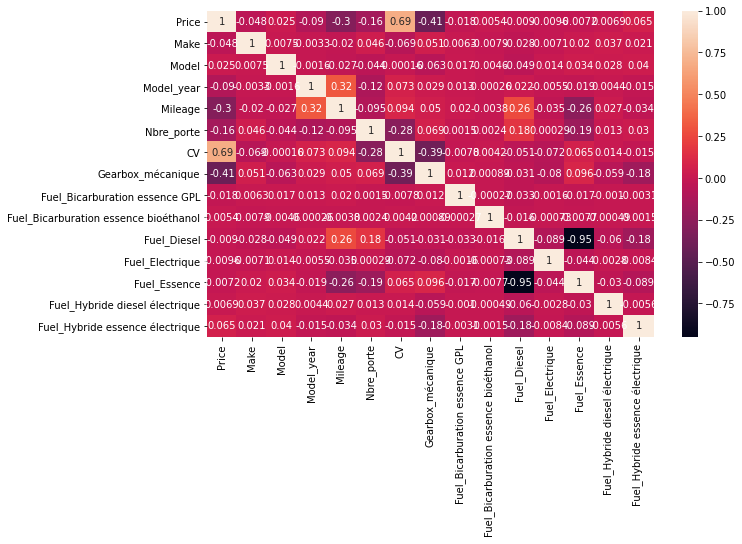

In [57]:
plt.figure(figsize=(10,6))
sns.heatmap(df1.corr(), annot=True)

In [58]:
df1.describe()

,Price,Make,Model,Model_year,Mileage,Nbre_porte,CV,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
count,1.654060e+05,165406.000000,165406.000000,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05,1.654060e+05
mean,-3.848992e-17,39.353445,396.165067,2.777202e-17,-7.446682e-17,-1.217630e-16,-7.057916e-17,-5.584474e-17,-1.890130e-17,-2.019002e-18,7.508970e-17,-1.454111e-17,2.818012e-17,-6.443624e-20,1.372492e-17
std,1.000000e+00,28.606948,242.153880,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.181576e+00,0.000000,0.000000,-3.619146e+02,-9.736248e-01,-6.108825e+00,-1.491058e+00,-1.448668e+00,-2.409821e-02,-1.126835e-02,-1.381719e+00,-6.472251e-02,-6.869081e-01,-4.333225e-02,-1.291578e-01
25%,-4.894108e-01,8.000000,208.000000,-2.866340e-01,-7.829119e-01,4.026916e-01,-4.352484e-01,-1.448668e+00,-2.409821e-02,-1.126835e-02,-1.381719e+00,-6.472251e-02,-6.869081e-01,-4.333225e-02,-1.291578e-01
50%,-2.164710e-01,34.000000,371.000000,-1.661315e-01,-3.403862e-01,4.026916e-01,-2.240865e-01,6.902852e-01,-2.409821e-02,-1.126835e-02,7.237319e-01,-6.472251e-02,-6.869081e-01,-4.333225e-02,-1.291578e-01
75%,2.070963e-01,53.000000,590.000000,1.953760e-01,5.488875e-01,4.026916e-01,1.982373e-01,6.902852e-01,-2.409821e-02,-1.126835e-02,7.237319e-01,-6.472251e-02,1.455790e+00,-4.333225e-02,-1.291578e-01
max,8.972695e+01,87.000000,830.000000,1.381216e+01,2.856731e+01,1.704995e+00,1.561306e+01,6.902852e-01,4.149661e+01,8.874361e+01,7.237319e-01,1.545048e+01,1.455790e+00,2.307736e+01,7.742422e+00


## X & Y 

In [59]:
Xfeatures = df1[[
    "Make",
    "Model", 
    "Model_year",
    "Mileage",
    "Fuel",
    "CV",
    "Nbre_porte",
    "Gearbox"   
]]
ylabels = df1['Price']

KeyError: "['Fuel', 'Gearbox'] not in index"

## Split Dataset

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(Xfeatures, ylabels, test_size=0.30, random_state=42)

NameError: name 'train_test_split' is not defined

In [61]:
lreg = LinearRegression()

NameError: name 'LinearRegression' is not defined

In [62]:
lreg.fit(X_train, Y_train)
y_pred = lreg.predict(X_test)

NameError: name 'lreg' is not defined

In [63]:
mean_squared_error(Y_test, y_pred)

NameError: name 'mean_squared_error' is not defined

In [64]:
mean_absolute_percentage_error(Y_test, y_pred)

NameError: name 'Y_test' is not defined

In [65]:
r2_score(Y_test, y_pred)

NameError: name 'r2_score' is not defined